### 데이터 전처리: 원본 로그의 정밀 재구조화

1) 데이터 타입(Type) 인식 및 문제점
    * **Pandas의 컬럼 단위 데이터 관리**: 동일 컬럼 내 데이터 타입 통일의 강제성 및 엄격성.
    * **Object 타입의 한계**: 전처리가 미비한 데이터는 대부분 문자열인 `object`로 인식됨. 이 상태에서는 산술 연산(합계, 평균)이 불가능하므로 수치형 변환이 필수적임.

2) 결측치(NaN/NULL) 탐색 및 진단
    * **결측치 정의**: 데이터베이스의 NULL과 동일한, 정보가 누락된 상태.
    * **isna() 메서드**: 데이터 부재 여부를 판단하여 True(1)/False(0) 반환.
    * **현황 파악**: `df.isna().sum()`을 실행하여 컬럼별 결측 규모를 산출하고, 이를 바탕으로 삭제 혹은 대체(Imputation) 전략 수립.

3) 날짜 데이터 및 수치 정제 (Cleaning)
    * **pd.to_datetime의 정교한 활용**:
        * `errors='coerce'`: 변환 불가능한 이상치를 에러 대신 NaT로 처리하여 전체 프로세스의 재현성 확보.
        * `format='mixed'`: 포맷이 혼재된(예: 2026-01-01과 2026/01/01) 날짜 데이터를 Pandas가 유추하여 표준화하도록 설정.
    * **수치형 데이터 정제 로직**:
        * 문자열 내 '원', 콤마(,) 등 비수치적 표기 제거 (`str.replace`, `str.strip`).
        * 연산을 위한 `astype(float)` 또는 `pd.to_numeric` 적용.
    * **파생 변수(Derived Variable) 생성**: 분석 효율 극대화를 위해 단가(price)와 수량(qty)을 결합한 매출(sales) 컬럼 등을 사전 설계.


In [ ]:
###오늘 배울 내용 : Line / Bar / Scatter / Hist / Box

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. 실습용 데이터
#전처리가 필요한 "현실 데이터" 상황을 만들기 위함
#날짜 형식 섞임, 문자열 숫자, 결측치 일부러 포함

raw = [
    {"date":"2026-01-01","store":"A","menu":"Americano","price":"4500원","qty":"2","paid":"TRUE"},
    {"date":"2026/01/01","store":"A","menu":"Latte","price":"5,000","qty":1,"paid":"True"},
    {"date":"2026-01-02","store":"A","menu":"Latte","price":None,"qty":2,"paid":"FALSE"},
    {"date":"2026-01-03","store":"B","menu":"Mocha","price":"5500","qty":None,"paid":True},
    {"date":"2026-01-03","store":"B","menu":"Americano","price":"4500","qty":1,"paid":"TRUE"},
    {"date":"2026-01-04","store":"B","menu":"Latte","price":"5000원","qty":"3","paid":"TRUE"},
]
df = pd.DataFrame(raw)
df.head()


: 

* pandas: 데이터 다루기(전처리, 집계)
* numpy: 숫자 처리 보조
* matplotlib: 모든 그래프의 기본 엔진(축/제목/레이아웃 제어)
* seaborn: 통계형 그래프를 빠르고 예쁘게 그리기

In [ ]:
### 2. 전처리

    #시각화는 "그리기" 전에 반드시 데이터가 맞는지 검증해야 함
    #(전처리 결과를 시각화로 확인하는 것도 중요한 목적)

# 날짜
    # - 문자열 날짜를 datetime으로 변환
    # - 실패하면 NaT로 처리하여 이후 에러 방지
df["date"] = pd.to_datetime(df["date"], errors="coerce", format="mixed")

# price 문자열 → 숫자
    #"4500원", "5,000" 같은 형식 정리 
    #숫자로 변환 불가능하면 NaN
df["price"] = (
    df["price"].astype("string")
    .str.replace(",", "", regex=False)
    .str.replace("원", "", regex=False)
)
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# qty 숫자화
    #문자열/결측 섞여 있으므로 숫자로 통일
df["qty"] = pd.to_numeric(df["qty"], errors="coerce")

# paid 컬럼 bool 통일
    #TRUE / True / False 등 섞인 값을 True / False로 통일
df["paid"] = (df["paid"].astype("string").str.upper() == "TRUE")

# 매출
    #매출 파생 변수
    #시각화용 핵심 지표
    #결측이 있으면 sales도 NaN이 됨 (의도된 결과)
df["sales"] = df["price"] * df["qty"]

df

,date,store,menu,price,qty,paid,sales
0,2026-01-01,A,Americano,4500,2.0,True,9000.0
1,2026-01-01,A,Latte,5000,1.0,True,5000.0
2,2026-01-02,A,Latte,<NA>,2.0,False,<NA>
3,2026-01-03,B,Mocha,5500,NaN,True,<NA>
4,2026-01-03,B,Americano,4500,1.0,True,4500.0
5,2026-01-04,B,Latte,5000,3.0,True,15000.0


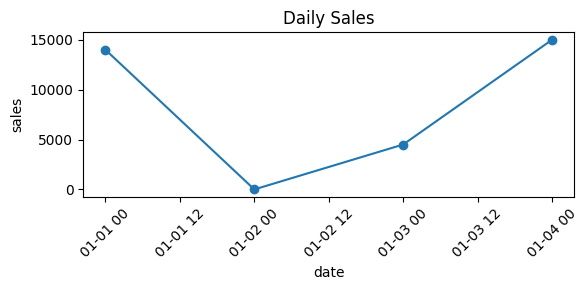

In [ ]:
##**(1) Matplotlib 예제: 일별 매출 라인 그래프**

import matplotlib.pyplot as plt

daily = df.groupby("date", as_index=False)["sales"].sum()

plt.figure(figsize=(6,3))
plt.plot(daily["date"], daily["sales"], marker="o")
plt.title("Daily Sales")
plt.xlabel("date")
plt.ylabel("sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

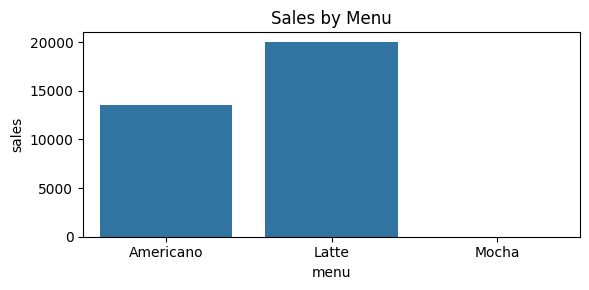

In [ ]:
#**Seaborn 예제: 메뉴별 매출 막대 그래프**

import seaborn as sns

menu_sales = df.groupby("menu", as_index=False)["sales"].sum()

plt.figure(figsize=(6,3))
sns.barplot(data=menu_sales, x="menu", y="sales")
plt.title("Sales by Menu")
plt.tight_layout()
plt.show()

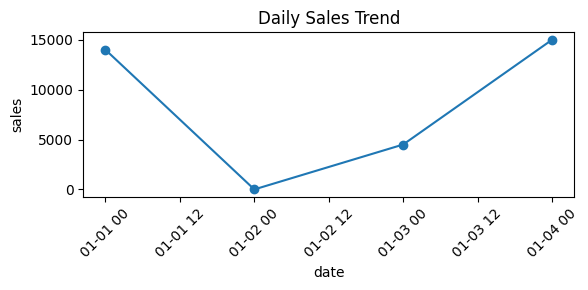

In [ ]:
### 3. Line Plot: 일별 매출 추이
#우리 매출이 날짜별로 오르고 있나?”

# 질문 유형: 시간에 따른 변화(추이)
# → Line Plot 선택

# 핵심 포인트:
# 1) 날짜 기준으로 집계(groupby)
# 2) 날짜 정렬(sort_values)
# 3) 원본 그대로 그리지 않는다

daily = (
    df.groupby("date", as_index=False)["sales"]
    .sum()
    .sort_values("date")
)

plt.figure(figsize=(6,3))
plt.plot(daily["date"], daily["sales"], marker="o")
plt.title("Daily Sales Trend")
plt.xlabel("date")
plt.ylabel("sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 해석 포인트:
# - 날짜가 뒤로 갈수록 매출이 증가/감소/변동하는지
# - 변화 원인이 price인지 qty인지 추가 분해 필요

In [ ]:
#매장별 일별 매출 비교

##A 매장 데이터 준비
df_a = df[df["store"] == "A"].dropna(subset=["date"]).copy()    #df["store"] == "A" → store가 A인 행만 필터링
                            #dropna(subset=["date"]) → date 컬럼이 결측치인 행 제거
                            #.copy() → 원본 df를 안전하게 보호, 새로운 DataFrame 생성
daily_a = df_a.groupby("date", as_index=False)["sales"].sum().sort_values("date")       #groupby("date", as_index=False) → 날짜별로 그룹화
                        #["sales"].sum() → 그룹별 sales 합계 계산
                        #.sort_values("date") → 날짜순으로 정렬
df_a
ㅍ
df_b = df[df["store"] == "B"].dropna(subset=["date"]).copy()    
daily_b = df_b.groupby("date", as_index=False)["sales"].sum().sort_values("date")
daily_b

#B 매장데이터 준비
plt.figure(figsize=(6,3))   #크기(가로 6, 세로 3)
plt.plot(daily_a["date"], daily_a["sales"], color="tab:orange", marker="o") #A 매장 매출을 오렌지색 점선
plt.plot(daily_b["date"], daily_b["sales"], color="tab:blue", marker="o")   #B 매장 매출을 파란색 점선
plt.title("Daily Sales Trend")
plt.xlabel("date"); plt.ylabel("sales") #B 매장 매출을 파란색 점선
plt.xticks(rotation=45)             #x축 라벨 45도 회전
plt.tight_layout()                #레이아웃 겹치지 않도록 자동 조정
plt.show()

NameError: name 'ᄑ' is not defined

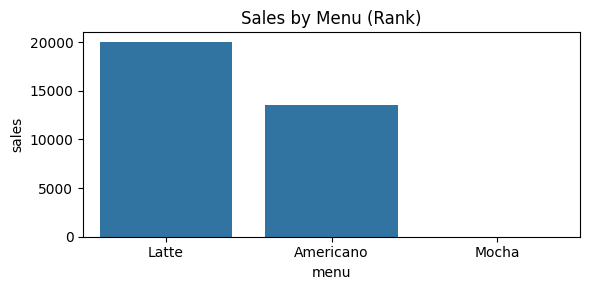

In [ ]:
##4. Bar Plot: 메뉴별 매출 순위
#“메뉴 중 뭐가 제일 잘 팔리나?”

# 질문 유형: 항목 간 크기 비교(순위)
# → Bar Plot 선택

# 핵심 포인트:
# 1) 메뉴별 집계(groupby)
# 2) 순위 비교를 위해 정렬(sort_values)

menu_sales = (
    df.groupby("menu", as_index=False)["sales"]
    .sum()
    .sort_values("sales", ascending=False)
)

plt.figure(figsize=(6,3))
sns.barplot(data=menu_sales, x="menu", y="sales")
plt.title("Sales by Menu (Rank)")
plt.tight_layout()
plt.show()

# 해석 포인트:
# - 매출 1등 메뉴 확인
# - 매출이 높은 이유가 가격인지 수량인지 추가 확인 가능

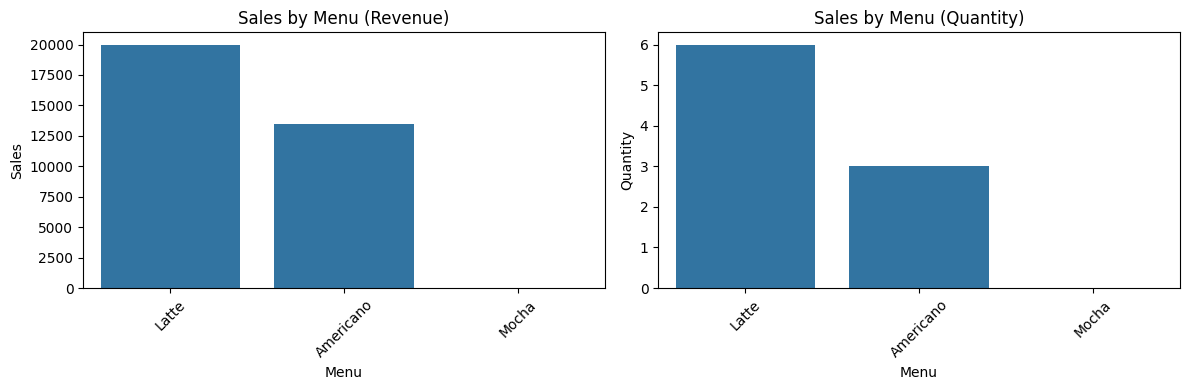

In [ ]:
#미션 (qty 기준으로도 동일한 그래프를 그려서 “매출 1등”과 “판매량 1등”이 같은지 비교

## 1) 매출 기준: 메뉴별 집계 후 정렬
menu_sales = (df.groupby("menu", as_index=False)["sales"]
              .sum()
              .sort_values("sales", ascending=False))

## 2) 판매량 기준: 메뉴별 집계 후 정렬
menu_qty = (
    df.groupby("menu", as_index=False)["qty"]
    .sum()
    .sort_values("qty", ascending=False)
)

# 3) 그래프 나란히 그리기
# 시각화
plt.figure(figsize=(12,4))

# 1) 매출 기준
plt.subplot(1,2,1)  # 1행 2열 중 1번째 그래프
sns.barplot(data=menu_sales, x="menu", y="sales")
plt.title("Sales by Menu (Revenue)")
plt.xlabel("Menu")
plt.ylabel("Sales")
plt.xticks(rotation=45)

# 2) 판매량 기준
plt.subplot(1,2,2)  # 1행 2열 중 2번째 그래프
sns.barplot(data=menu_qty, x="menu", y="qty")
plt.title("Sales by Menu (Quantity)")
plt.xlabel("Menu")
plt.ylabel("Quantity")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



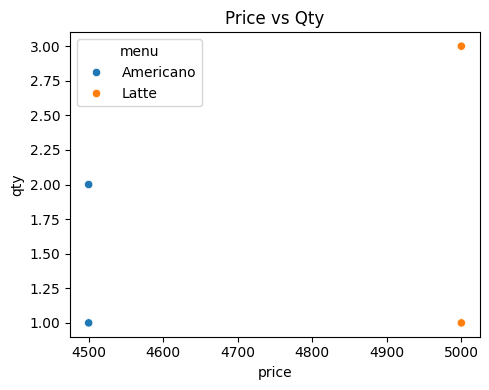

In [ ]:
### 5. Scatter Plot: 가격 vs 수량 관계

# 질문 유형: 두 변수 간 관계
# → Scatter Plot 선택

# 핵심 포인트:
# - x, y 둘 다 필요하므로 결측 제거 필수

tmp = df.dropna(subset=["price", "qty"])

plt.figure(figsize=(5,4))
sns.scatterplot(data=tmp, x="price", y="qty", hue="menu")
plt.title("Price vs Qty")
plt.tight_layout()
plt.show()

# 해석 포인트:
# - 가격이 높을수록 수량이 줄어드는지/늘어나는지
# - 표본이 적으므로 결론이 아닌 가설 수준

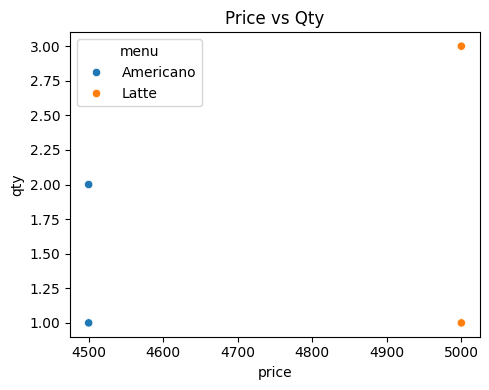

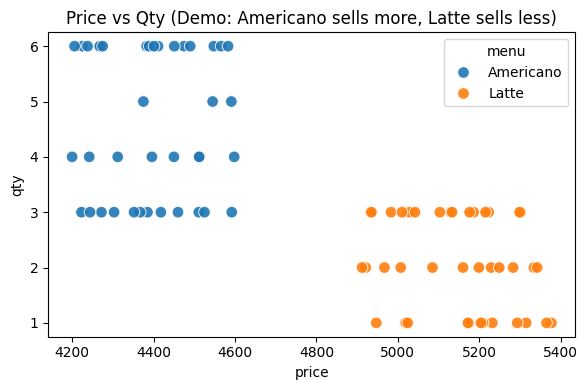

,menu,price,qty,sales
0,Americano,4375,5,21875
1,Americano,4396,4,17584
2,Americano,4225,6,25350
3,Americano,4267,6,25602
4,Americano,4411,6,26466


In [ ]:
tmp = df.dropna(subset=["price","qty"])

plt.figure(figsize=(5,4))
sns.scatterplot(data=tmp, x="price", y="qty", hue="menu")
plt.title("Price vs Qty")
plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(7)

n = 40  # 점 개수(원하는 만큼 늘려도 됨)

# Americano: 저가 + 수량 많음
a_price = np.random.randint(4200, 4601, size=n)
a_qty   = np.random.randint(3, 7, size=n)   # 3~6

# Latte: 고가 + 수량 적음
l_price = np.random.randint(4900, 5401, size=n)
l_qty   = np.random.randint(1, 4, size=n)   # 1~3

df_demo = pd.DataFrame({
    "menu":  ["Americano"] * n + ["Latte"] * n,
    "price": np.concatenate([a_price, l_price]),
    "qty":   np.concatenate([a_qty, l_qty]),
})

# (선택) 판매금액도 같이 보고 싶으면
df_demo["sales"] = df_demo["price"] * df_demo["qty"]

# 산점도
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_demo, x="price", y="qty", hue="menu", s=70, alpha=0.9)

plt.title("Price vs Qty (Demo: Americano sells more, Latte sells less)")
plt.xlabel("price")
plt.ylabel("qty")
plt.tight_layout()
plt.show()

df_demo.head()

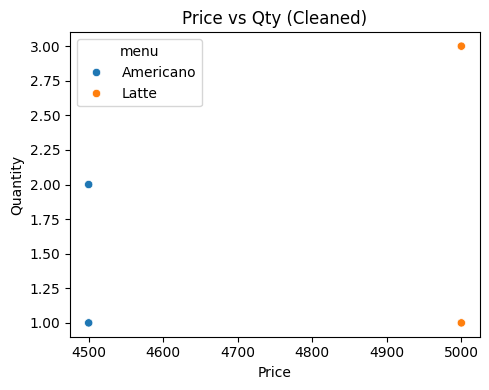

In [ ]:
#미션 (sales가 0/NaN이 되는 행이 왜 생겼는지 원인을 적고, 처리 후 다시 그리기.)

##원인
#sales를 보통 price * qty로 계산하는데 price 또는 qty 중 하나라도 NaN이면 결과가 NaN가 됨.
#price 또는 qty가 0인 경우, 곱하면 sales가 0이 됨
#데이터셋에서 누락된 값 또는 잘못 입력된 값 때문에 이런 행 생김


##처리 방법
#dropma로 NaN 제거: dropna()를 사용해 NaN 있는 행 삭제
tmp = df.dropna(subset=["price","qty"])

#0 처리: 필요시 0을 제외하거나, 특정 값으로 대체 가능
tmp = tmp[(tmp["price"] > 0) & (tmp["qty"] > 0)]

#sales 컬럼 재계산:
tmp["sales"] = tmp["price"] * tmp["qty"]


###시각화
plt.figure(figsize=(5,4))  # 그래프 크기 설정 (가로 5, 세로 4)
sns.scatterplot(
    data=tmp,               # 사용할 데이터프레임 지정
    x="price",              # x축: 가격
    y="qty",                # y축: 판매 수량
    hue="menu"              # 색상으로 메뉴 구분 (Americano / Latte)
)
plt.title("Price vs Qty (Cleaned)")  # 그래프 제목
plt.xlabel("Price")                  # x축 라벨
plt.ylabel("Quantity")               # y축 라벨
plt.tight_layout()                   # 레이아웃 자동 조정 (라벨/제목 겹치지 않도록)
plt.show()                           # 그래프 출력


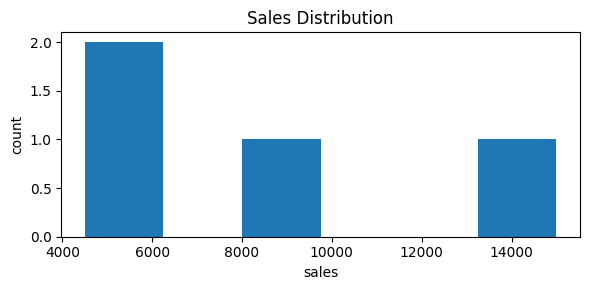

In [ ]:
### 6. Histogram: 매출 분포

# 질문 유형: 값이 어떻게 퍼져 있나(분포)
# → Histogram 선택

# 핵심 포인트:
# - sales 결측 제거
# - bins 개수에 따라 분포 인상이 달라짐

tmp = df.dropna(subset=["sales"])

plt.figure(figsize=(6,3))
plt.hist(tmp["sales"], bins=6)
plt.title("Sales Distribution")
plt.xlabel("sales")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# 해석 포인트:
# - 매출이 특정 구간에 몰려 있는지
# - 일부 큰 값이 평균을 끌어올리는지 확인 가능

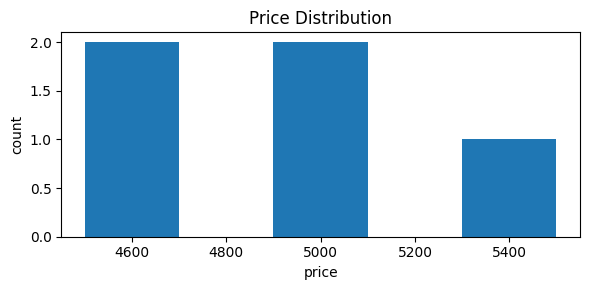

In [ ]:
# price 분포 확인
tmp = df.dropna(subset=["price"])  # 가격 결측치 제거

plt.figure(figsize=(6,3))
plt.hist(tmp["price"], bins=5)     # 히스토그램, 5개 구간으로 나누기
plt.title("Price Distribution")    # 그래프 제목
plt.xlabel("Price")                # x축 라벨
plt.ylabel("Count")                # y축 라벨
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_4976\2333775625.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["sales"] = tmp["price"] * tmp["qty"]    ## 각 거래 매출 계산


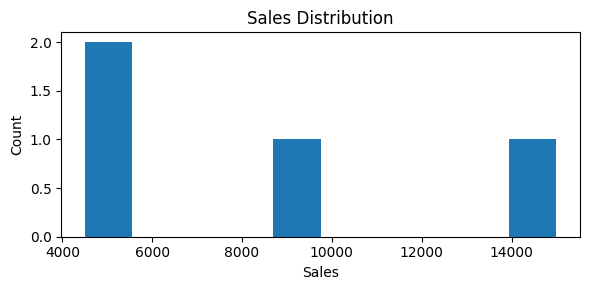

In [ ]:
#미션 (sales(매출) 분포도 확인하고, “한두 건이 전체를 끌어올리는지” 토론하기.)

# 결측치 제거
tmp = df.dropna(subset=["price", "qty"])    ## price, qty 결측치 제거

# sales 컬럼 생성
tmp["sales"] = tmp["price"] * tmp["qty"]    ## 각 거래 매출 계산

# 히스토그램으로 매출 분포 확인
plt.figure(figsize=(6,3))
plt.hist(tmp["sales"], bins=10)  # 10개 구간으로 나누어 히스토그램 생성
plt.title("Sales Distribution")  # 히스토그램 제목
plt.xlabel("Sales")              # x축: 매출 금액
plt.ylabel("Count")              # y축: 거래 수
plt.tight_layout()
plt.show()


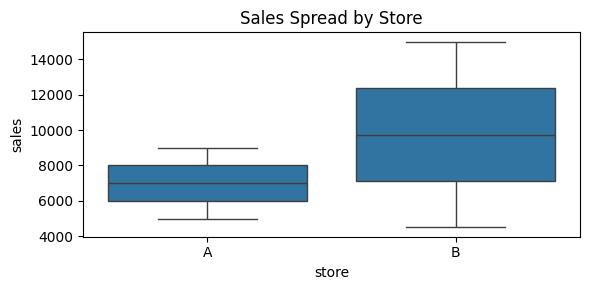

In [ ]:
### 7. Box Plot: 매장별 매출 분포

# 질문 유형: 이상치 / 범위 / 안정성 비교
# → Box Plot 선택

# 박스플롯이 보여주는 것:
# - 중앙값
# - IQR(중간 50%)
# - 이상치 후보

plt.figure(figsize=(6,3))
sns.boxplot(data=tmp, x="store", y="sales")
plt.title("Sales Spread by Store")
plt.tight_layout()
plt.show()

# 해석 포인트:
# - 어느 매장이 매출 변동이 더 안정적인지
# - 튀는 값이 특정 메뉴/수량 때문인지 추가 분석 가능

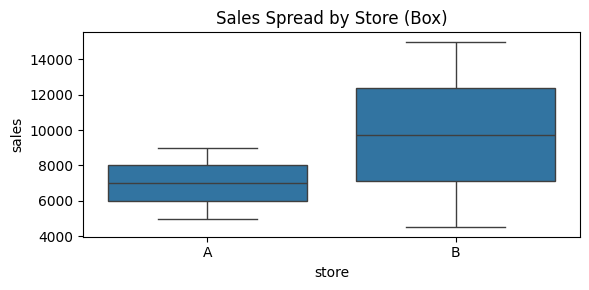

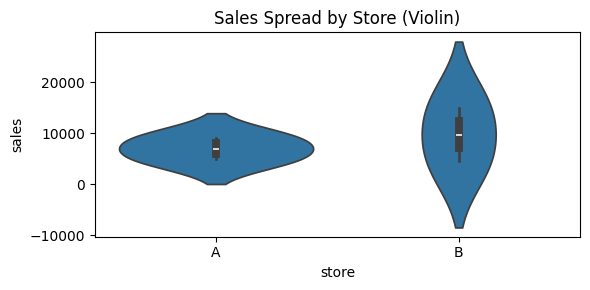

In [ ]:
# 결측치 제거 후 store별 매출 확인
tmp = df.dropna(subset=["sales"])  # sales가 없는 행 제거

# 1) Box Plot: store별 매출 분포 확인
plt.figure(figsize=(6,3))
sns.boxplot(data=tmp, x="store", y="sales")
plt.title("Sales Spread by Store (Box)")  # Boxplot 제목
plt.tight_layout()
plt.show()

# 해석 주석:
# - 박스 안: 중앙 50% 데이터(IQR: Q1~Q3)
# - 박스 가운데 선: 중앙값(Median)
# - 상/하위 선(whisker): 통상 Q1-1.5*IQR ~ Q3+1.5*IQR
# - 점(있으면): 이상치(Outlier)
# - store별로 매출 범위와 이상치 비교 가능

# 2) Violin Plot: boxplot + 분포 밀도 확인
plt.figure(figsize=(6,3))
sns.violinplot(data=tmp, x="store", y="sales")
plt.title("Sales Spread by Store (Violin)")  # Violin plot 제목
plt.tight_layout()
plt.show()

# 해석 주석:
# - 폭: 해당 값에서 데이터가 얼마나 많은지 밀도(Density)
# - 중앙값과 IQR은 박스플롯과 동일하게 표시
# - distribution 확인 가능 (예: 한쪽으로 치우친지, 극단값 존재 여부)
# - 매출이 일부 거래(고가) 때문에 한쪽으로 치우쳤는지 확인 가능


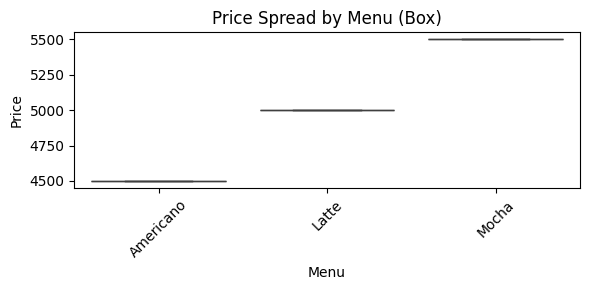

In [ ]:
#미션 (menu별 price 박스플롯을 그려서 “가격 변동이 큰 메뉴”를 찾기)

# 결측치 제거 후 메뉴별 가격 확인
tmp = df.dropna(subset=["price"])  # price가 없는 행 제거

# Box Plot: 메뉴별 가격 분포 확인
plt.figure(figsize=(6,3))
sns.boxplot(data=tmp, x="menu", y="price")
plt.title("Price Spread by Menu (Box)")
plt.xlabel("Menu")
plt.ylabel("Price")
plt.xticks(rotation=45)  # 메뉴 이름이 겹치면 회전
plt.tight_layout()
plt.show()

# 해석 주석:
# - 박스 안: 해당 메뉴의 중앙 50% 가격 범위(IQR)
# - 박스 가운데 선: 중앙값(Median)
# - 상/하위 선(whisker): 일반적인 가격 범위(Q1-1.5*IQR ~ Q3+1.5*IQR)
# - 점(있으면): 이상치, 가격이 일반 범위를 크게 벗어난 경우
# - 박스가 길수록 가격 변동이 큰 메뉴
#   → 예: Latte 박스가 길면 다양한 옵션/사이즈 가격이 존재


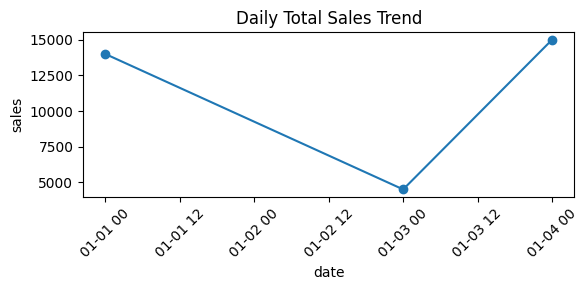

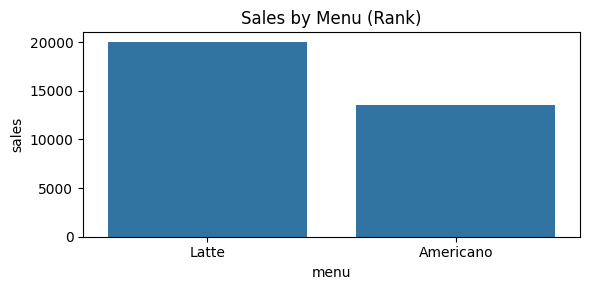

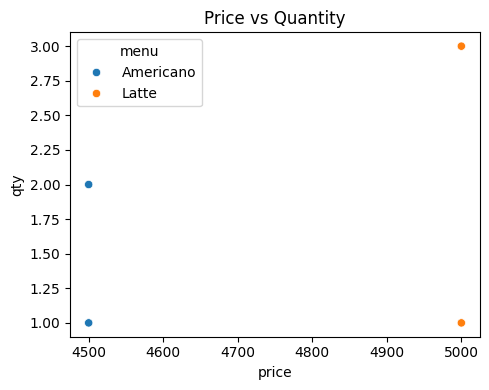

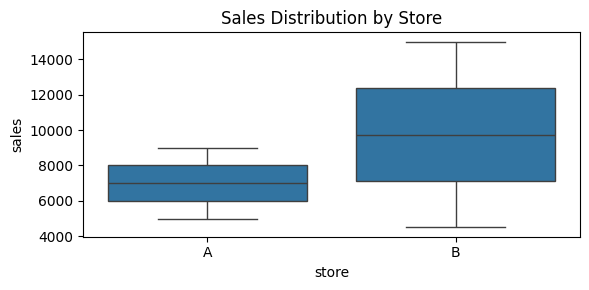

In [ ]:
##### 카페 운영 대시보드 4컷 만들기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1️ 일별 총매출 추이 (Line Plot)
# ==============================

# 날짜와 매출이 있는 행만 사용 (결측치 제거)
daily_sales = (
    df.dropna(subset=["date", "sales"])
      # 날짜 단위로 매출 합계 계산
      .groupby("date", as_index=False)["sales"]
      .sum()
      # 시간 흐름을 보기 위해 날짜 기준 정렬
      .sort_values("date")
)

plt.figure(figsize=(6,3))
# 날짜별 총매출 변화 추이를 선 그래프로 표현
plt.plot(daily_sales["date"], daily_sales["sales"], marker="o")
plt.title("Daily Total Sales Trend")
plt.xlabel("date")
plt.ylabel("sales")
# 날짜 라벨 겹침 방지
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 해석:
# - 날짜별 총매출 흐름을 통해 매출 증가/감소 패턴을 확인할 수 있음
# - 특정 날짜의 급격한 변화는 이벤트, 요일 효과 등을 의심해볼 수 있음


# ==============================
# 2️ 메뉴별 매출 순위 (Bar Plot)
# ==============================

menu_sales = (
    df.dropna(subset=["menu", "sales"])
      # 메뉴별 매출 합계 계산
      .groupby("menu", as_index=False)["sales"]
      .sum()
      # 매출 기준 내림차순 정렬 → 순위 비교 목적
      .sort_values("sales", ascending=False)
)

plt.figure(figsize=(6,3))
# 메뉴별 매출 크기 비교를 위한 막대그래프
sns.barplot(data=menu_sales, x="menu", y="sales")
plt.title("Sales by Menu (Rank)")
plt.tight_layout()
plt.show()

# 해석:
# - 메뉴별 매출 규모를 비교하여 매출 1등 메뉴를 파악할 수 있음
# - 매출이 높은 이유가 가격인지, 판매량인지 추가 분석 가능


# ==============================
# 3 가격 vs 수량 관계 (Scatter Plot)
# ==============================

# 가격과 수량이 모두 존재하는 데이터만 사용
tmp = df.dropna(subset=["price", "qty"])

plt.figure(figsize=(5,4))
# 가격과 판매수량의 관계를 산점도로 표현
# 메뉴별 색상 구분으로 메뉴 특성 비교
sns.scatterplot(data=tmp, x="price", y="qty", hue="menu")
plt.title("Price vs Quantity")
plt.xlabel("price")
plt.ylabel("qty")
plt.tight_layout()
plt.show()

# 해석:
# - 가격이 높을수록 판매량이 줄어드는 경향이 있는지 확인 가능
# - 메뉴별로 가격 전략과 판매 패턴의 차이를 비교할 수 있음


# ==============================
# 4️ 매장별 매출 분포 (Box Plot)
# ==============================

# 매장과 매출 데이터만 사용
tmp = df.dropna(subset=["store", "sales"])

plt.figure(figsize=(6,3))
# 매장별 매출 분포를 박스플롯으로 시각화
sns.boxplot(data=tmp, x="store", y="sales")
plt.title("Sales Distribution by Store")
plt.tight_layout()
plt.show()

# 해석:
# - 매장별 매출의 중앙값과 변동 폭을 비교할 수 있음
# - 이상치(outlier)를 통해 특정 매장의 매출 변동성 여부를 확인 가능


### 정리) 시각화 전략: 질문 중심의 차트 선택 및 구현

1) Line Plot (선 그래프): 시계열 추세 파악
    * **질문**: "시간의 흐름에 따라 매출 지표가 어떻게 변화하는가?"
    * **핵심 요건**: x축 날짜 데이터가 반드시 `datetime` 타입이어야 시간 순서에 따른 올바른 시각화가 가능함.
    * **분석 포인트**: 포인트 간 연결을 통한 경향성 및 계절성 확인.

2) Bar Plot (막대 그래프): 범주형 데이터 비교
    * **질문**: "매장별/메뉴별 매출 합계 및 성과의 차이는 어떠한가?"
    * **다차원 분석**: `hue` 옵션을 활용하여 특정 카테고리 내 세부 항목(예: 매장별 메뉴 비중) 비교.
    * **특징**: 이산적 카테고리 간의 크기 차이를 직관적으로 식별하기에 최적임.

3) Scatter Plot (산점도): 두 변수 간 상관관계
    * **질문**: "판매 단가와 판매 수량 사이에 어떠한 관계가 존재하는가?"
    * **데이터 무결성**: x축과 y축 모두 수치형이어야 하며, 결측치(`dropna`)가 제거된 상태에서만 정확한 상관 분석이 가능함.
    * **해석**: 양(+), 음(-)의 상관관계 확인 및 전체 흐름에서 벗어난 이상치 탐색.

4) Histogram (히스토그램): 데이터 밀도 및 분포
    * **질문**: "매출 규모가 특정 구간에 얼마나 집중되어 있는가?"
    * **파라미터 설정**: `bins`(구간 개수) 설정에 따라 분포의 인상이 달라지므로 데이터 특성에 맞는 적절한 구간화가 필수임.
    * **목적**: 데이터의 치우침(Skewness) 및 집중 경향성 파악.

5) Box Plot (상자 수염 그림): 통계적 변동성 및 이상치
    * **질문**: "데이터의 중앙값은 어디이며, 극단적인 이상치는 존재하는가?"
    * **구성 체계**: 중앙값, 사분위수(IQR), 최소/최대값 및 Outliers를 동시 시각화.
    * **활용도**: 데이터 편차 확인 및 데이터 품질 진단에 가장 강력한 통계적 도구임.

### +) 분석 결과의 비판적 해석 및 가설 수립
* **데이터 크기의 한계성 인식**: 적은 수의 표본(실습 데이터 6건 등) 기반 시각화는 결론이 아닌 **'추가 검증용 가설'**로 취급해야 함.
* **분석가의 통찰**: "가격 상승 시 수량이 감소하는가?"와 같은 가설을 수립하고, 향후 대용량 데이터를 통해 이를 입증하는 프로세스가 분석의 핵심임.

## 5. [인사이트] 현업 분석가의 에피소드 및 데이터 해석 팁

### 5.1 시각화의 비즈니스적 가치와 청중
* **설득을 위한 시각화**: 그래프는 본인의 확인용을 넘어 의사결정자(클라이언트, 상사)를 설득하기 위한 최종 결과물임.
* **질문의 선제적 정의**: "무슨 그래프를 그릴까"가 아닌 "내가 어떤 비즈니스 질문에 답해야 하는가"를 먼저 확립해야 함.
    * 예: 매출 추세가 궁금하면 Line, 항목 간 격차가 궁금하면 Bar를 선택하는 논리적 근거 필요.
* **해석의 책임성**: 결과물에 대해 "왜 이런 수치가 나왔는가"라는 질문을 받았을 때, 데이터에 근거한 가설이나 논리를 제시할 수 있어야 함.

### 5.2 데이터 해석의 통계적 경계: 가설과 확신
* **표본 크기의 함정**: 실습 데이터와 같이 소규모 샘플(예: 6건)로 도출된 시각화 결과는 결코 '확정적 결론'이 될 수 없음.
* **가설 수립 도구로서의 활용**: 적은 데이터로 만든 그래프는 "이러한 경향성이 존재할 가능성이 있다"는 **가설(Hypothesis)** 수립용으로만 제한적 사용 권장.
* **분석의 선순환 구조**: 수립된 가설을 대용량 데이터에서 재검증하여 비즈니스 모델을 정교화하는 과정이 분석가의 핵심 업무임.

### 5.3 실무 전처리의 실상과 방어적 접근
* **데이터의 비표준성**: 현업에서 수령하는 원본 데이터는 포맷 불일치, 오타, 비수치 데이터가 혼재된 '지저분한' 상태가 기본값임.
* **방어적 코딩의 필요성**: `errors='coerce'`와 같은 옵션은 예외 상황에서 시스템이 멈추지 않도록 NaT/NaN으로 우회 처리하여 분석의 연속성을 확보하는 실무적 지혜임.
* **기술 환경 변화에 대한 기민함**: Pandas 2.x 버전의 `format='mixed'` 옵션 도입과 같이, 도구의 변화에 맞춰 최신 기법을 습득하는 자세가 필요함.

### 5.4 분석가의 마인드셋: 톱니바퀴 이론 (Flywheel)
* **초기 마찰력의 이해**: 학습 초반 코드가 작성되지 않고 로직이 이해되지 않는 답답함은 '녹슨 톱니바퀴'를 처음 돌릴 때 발생하는 자연스러운 현상임.
* **임계점(Critical Point) 돌파**: 초기 구동력을 투입하여 한두 바퀴를 어렵게 돌리고 나면, 어느 순간 지식이 서로 연결되며 스스로 회전하는 '가속도'가 붙게 됨.
* **컨디션 관리와 지속성**: "사람같이 살아야 분석도 잘 된다"는 조언처럼, 장기적인 분석 프로젝트 수행을 위해 분석가 개인의 컨디션 관리와 여유를 갖는 것도 실력의 일부임.

## ⚓ 그래프의 품격: 시각화 꾸미기 및 실무 FAQ

### 🚢 1. 그래프 예쁘게 꾸미기 (초보 필수 7대 원칙)
"꾸미기"는 최소한으로 하되, 효과가 즉각적인 핵심 요소에만 집중하기.

* **공간 확보**: `figsize=(w, h)`로 도화지 크기를 넉넉하게 조절하기.
* **라벨링의 정석**: `title`, `xlabel`, `ylabel`을 통해 그래프의 정보를 명확히 전달한다.
* **가독성 필살기**: `xticks(rotation=45)`로 겹치는 글자를 눕히고, `tight_layout()`으로 여백을 자동 최적화.
* **데이터의 식별**: `plt.legend()` 또는 Seaborn의 `hue` 옵션으로 범례를 활용해 그룹을 구분한다.
* **정렬의 미학**: 순위 그래프는 반드시 데이터를 **정렬(Sort)**한 후 그려야 가독성이 올라간다.
* **무결성 유지**: 결측치(NaN)를 제거하거나 대체한 후 그려서 그래프 엔진의 오류를 예방함.

---

### 🌊 2. 입문 분석가를 위한 긴급 SOS (FAQ)

* **Q. 그래프가 나타나지 않습니다!**
    * **A.** `plt.show()` 명령어가 빠졌거나, 컬럼명 오타, 혹은 숫자축에 문자열이 섞여 있는지 확인하기.
* **Q. 시계열(Line Plot) 날짜가 엉망입니다.**
    * **A.** `pd.to_datetime` 처리가 필수. 변환 실패 시 `NaT`가 발생하므로 이를 먼저 정제하기.
* **Q. 막대그래프(Bar Plot) 수치가 이상합니다.**
    * **A.** 원본 데이터를 그대로 그리면 중복 막대가 생길 수 있습니다. `groupby().sum()` 등으로 먼저 집계하는 습관을 들이기.
* **Q. Seaborn vs Matplotlib, 무엇이 더 좋은가요?**
    * **A.** 빠른 시각화와 기본 디자인은 **Seaborn**이 우수하며, 세밀한 커스텀 보고서는 **Matplotlib**의 조합이 good

---

### 💎 3. 다음 보물을 향한 항해 루트 (추천 학습 순서)

1.  **기초 항해**: Line / Bar 차트로 **[집계 + 정렬]** 기술 익히기
2.  **관계 탐색**: Scatter Plot으로 **[변수 간 관계 + 결측 제거]** 연습
3.  **심해 탐사**: Histogram / Box Plot으로 **[데이터 분포 + 이상치]** 감 잡기
4.  **최종 관문**: 종합 4컷 대시보드(미니 프로젝트) 무한 반복

> **[다음 수업 예고]** > 이제 시각화는 단순한 그림이 아닌 **'데이터 검증 도구'**가 된다. 
> * 피벗테이블(pivot_table)을 활용한 대시보드 구축 
> * 카테고리가 20개 이상인 대규모 데이터 시각화 전략 
> * 실제 CSV 데이터 로드 및 전처리 루틴 반복

In [ ]:
#!python -m jupyter nbconvert --to markdown 04_real.ipynb

[NbConvertApp] Converting notebook 04_real.ipynb to markdown
[NbConvertApp] Support files will be in 04_real_files\
[NbConvertApp] Writing 24161 bytes to 04_real.md
